Licensed under the MIT License.

Copyright (c) 2025-2035. All rights reserved by Hanhan Wu.

Permission is hereby granted to view this code for evaluation purposes only.
You may not reuse, copy, modify, merge, publish, distribute, sublicense,
or exploit this code without Hanhan Wu's EXPLICIT written permission.


# Performance Comparison with Bigger Finance Q&A Data

* Dataset
  * 30 training records
  * 30 validation records
  * 30 testing records
* Baseline vs DsPy vs Adalflow
* Same initial prompt, save testset

In [6]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dspy
import contextlib
import openai
from concurrent.futures import ThreadPoolExecutor, as_completed

from utils import *

import warnings
warnings.filterwarnings('ignore')


model_str = 'gpt-4.1-nano'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Testset

In [7]:
# testet format for baseline and Adalflow
test_df = pd.read_parquet('final_finance_qa_test.parquet')
print(test_df.shape)
display(test_df.head())

# testet format for Dspy
dspy_testset = [
    dspy.Example({
        "question": record['question'],
        "context": list(record['context']),
        "ground_truth": record['ground_truth']
        }).with_inputs('question', 'context')
    for record in test_df.to_dict(orient='records')
]
print(len(dspy_testset))
print(dspy_testset[0])

(30, 4)


,doc_id,context,question,ground_truth
0,9808.jpeg,[### Document Type\nThe document is an invoice...,What is the invoice date of the document?,"The invoice date is December 22, 1993."
1,7461.jpeg,[### Document Type:\nThis is a Print Productio...,What is the client's name mentioned in the Pri...,The client's name is Philip Morris Inc.
2,5471.jpeg,[### Document Type\nThe document is a financia...,Who is the issuer of the invoice?,"Borrison Laboratories, Inc."
3,7440.jpeg,[### Document Type\nThis is a financial estima...,What is the name of the company that created t...,"Leo Burnett U.S.A., a division of Leo Burnett ..."
4,2613.jpeg,[### Document Type\nThe image shows a financia...,What is the issuer of the check?,The Tobacco Institute.


30
Example({'question': 'What is the invoice date of the document?', 'context': ["### Document Type\nThe document is an invoice from Fannon-Luers Associates Inc., a company that offers data processing, mailing, and fulfillment services.\n\n### Key Details\n- **Invoice Date:** December 22, 1993\n- **Invoice Number:** 25737\n- **Customer ID:** 108\n- **Company Address:** Tobacco Institute, 1875 I Street NW, 8th Floor, Washington, D.C. 20006\n- **Supplier's Address and Contact:** Fannon-Luers Associates Inc., 5352 - 46th Ave., Hyattsville, MD 20781; Phone: (301) 864-3776\n- **Page Number of Invoice:** 6\n- **Payment Terms:** Net 30\n- **Description and Amounts:**\n  - THYSN: Youth Requests - $1152.20\n    - Tasks: Process Mail, Data Entry, Merge Tape and Prepare Labels.\n    - Volume: 2000\n  - Postage and Mail (Matériel for third class) - $201.20\n  - General Postage Used - $466.00\n- **Total Amount Due:** $1819.20\n- **Sales Tax:** $0.00\n\n### Insights and Observations\n- **Vendor Serv

### Generate Answers

In [3]:
baseline_prompt = """Answer questions with short factoid answers. 
                    You will receive context(contain relevant facts). 
                    Think step by step."""

adalflow_prompt = """Answer questions with short factoid answers. 
                    You will receive context (contain relevant facts). Think step by step. 
                    Focus on extracting the most relevant factoid directly answering the question. 
                    Do not include explanations or additional commentary. 
                    Ensure the answer is concise, accurate, and based solely on the provided context."""

dspy_optimized_progfram = dspy.load("dspy_compiled_rag/")

In [ ]:
def process_row(row):
    context = "\n".join(row['context']) if isinstance(row['context'], (list, tuple)) else str(row['context'])
    question = row['question']
    ground_truth = row['ground_truth']
    baseline_answer = get_gpt_answer(baseline_prompt, question, context, model=model_str)
    adalflow_answer = get_gpt_answer(adalflow_prompt, question, context, model=model_str)
    return {
        "question": question,
        "context": context,
        "ground_truth": ground_truth,
        "baseline_answer": baseline_answer,
        "adalflow_answer": adalflow_answer,
    }

results = []
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(process_row, row) for _, row in test_df.iterrows()]
    for future in as_completed(futures):
        results.append(future.result())

results_df = pd.DataFrame(results)
print(results_df.shape)
display(results_df.head())

(30, 5)


,question,context,ground_truth,baseline_answer,adalflow_answer
0,What is the company's RIDE Code?,['### Document Type\nThe image shows a financi...,The company's RIDE Code is 471120.,471120,471120
1,What is the state covered in the State Contrib...,"['### Document Type\nThis is a ""State Contribu...",The state covered is New York.,New York,New York
2,Who is the issuer of the invoice?,['### Document Type\nThe document is a financi...,"Borrison Laboratories, Inc.","Borrison Laboratories, Inc.","Borrison Laboratories, Inc."
3,What is the client's name mentioned in the Pri...,['### Document Type:\nThis is a Print Producti...,The client's name is Philip Morris Inc.,Philip Morris Inc.,Philip Morris Inc.
4,What is the name of the company that created t...,['### Document Type\nThis is a financial estim...,"Leo Burnett U.S.A., a division of Leo Burnett ...",Leo Burnett U.S.A.,Leo Burnett U.S.A.


In [27]:
llm = dspy.LM(f"openai/{model_str}")
dspy.settings.configure(lm=llm)

dspy_results = []
for r in dspy_testset:
    pred = dspy_optimized_progfram(question=r.question, context=r.context)
    dspy_results.append({
        "question": r.question,
        "ground_truth": r.ground_truth,
        "dspy_answer": pred.answer
    })

dspy_results_df = pd.DataFrame(dspy_results)
print(dspy_results_df.shape)
dspy_results_df.head()

(30, 3)


,question,ground_truth,dspy_answer
0,What is the invoice date of the document?,"The invoice date is December 22, 1993.","December 22, 1993"
1,What is the client's name mentioned in the Pri...,The client's name is Philip Morris Inc.,Philip Morris Inc.
2,Who is the issuer of the invoice?,"Borrison Laboratories, Inc.","Borrison Laboratories, Inc."
3,What is the name of the company that created t...,"Leo Burnett U.S.A., a division of Leo Burnett ...",Leo Burnett U.S.A.
4,What is the issuer of the check?,The Tobacco Institute.,The Tobacco Institute


In [28]:
all_answer_df = results_df.merge(dspy_results_df, on=['question', 'ground_truth'], how='inner')
print(all_answer_df.shape)

all_answer_df.head()

(30, 6)


,question,context,ground_truth,baseline_answer,adalflow_answer,dspy_answer
0,What is the company's RIDE Code?,['### Document Type\nThe image shows a financi...,The company's RIDE Code is 471120.,471120,471120,471120
1,What is the state covered in the State Contrib...,"['### Document Type\nThis is a ""State Contribu...",The state covered is New York.,New York,New York,New York
2,Who is the issuer of the invoice?,['### Document Type\nThe document is a financi...,"Borrison Laboratories, Inc.","Borrison Laboratories, Inc.","Borrison Laboratories, Inc.","Borrison Laboratories, Inc."
3,What is the client's name mentioned in the Pri...,['### Document Type:\nThis is a Print Producti...,The client's name is Philip Morris Inc.,Philip Morris Inc.,Philip Morris Inc.,Philip Morris Inc.
4,What is the name of the company that created t...,['### Document Type\nThis is a financial estim...,"Leo Burnett U.S.A., a division of Leo Burnett ...",Leo Burnett U.S.A.,Leo Burnett U.S.A.,Leo Burnett U.S.A.


In [ ]:
def process_record(record):
    evals = {}
    for answer_type in ['baseline_answer', 'adalflow_answer', 'dspy_answer']:
        answer = record.get(answer_type)
        if answer is not None:
            eval_score, eval_reason = my_deepeval_answer_correctness(
                record['question'],
                list(record['context']),
                record['ground_truth'],
                answer
            )
            evals[f'{answer_type}_score'] = eval_score
            evals[f'{answer_type}_reason'] = eval_reason
        else:
            evals[f'{answer_type}_score'] = None
            evals[f'{answer_type}_reason'] = None
    return {**record, **evals}

final_eval_lst = []
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(process_record, record) for record in all_answer_df.to_dict(orient='records')]
    for future in as_completed(futures):
        final_eval_lst.append(future.result())

In [30]:
final_eval_df = pd.DataFrame(final_eval_lst)
print(final_eval_df.shape)
display(final_eval_df.head())

(30, 12)


,question,context,ground_truth,baseline_answer,adalflow_answer,dspy_answer,baseline_answer_score,baseline_answer_reason,adalflow_answer_score,adalflow_answer_reason,dspy_answer_score,dspy_answer_reason
0,Who is the issuer of the invoice?,['### Document Type\nThe document is a financi...,"Borrison Laboratories, Inc.","Borrison Laboratories, Inc.","Borrison Laboratories, Inc.","Borrison Laboratories, Inc.",1.000000,The Actual Output matches the Expected Output ...,1.000000,The Actual Output matches the Expected Output ...,0.989331,The Actual Output matches the Expected Output ...
1,Who issued the check?,['### Document Type:\nThis image depicts a fin...,The Tobacco Institute,The Tobacco Institute,The Tobacco Institute,The Tobacco Institute,1.000000,The Actual Output matches the Expected Output ...,1.000000,The Actual Output matches the Expected Output ...,0.997702,The Actual Output matches the Expected Output ...
2,What is the issuer of the check?,['### Document Type\nThe image shows a financi...,The Tobacco Institute.,The Tobacco Institute,The Tobacco Institute,The Tobacco Institute,0.872968,The Actual Output matches the Expected Output ...,0.873443,The Actual Output matches the Expected Output ...,0.877730,The Actual Output matches the Expected Output ...
3,What is the state covered in the State Contrib...,"['### Document Type\nThis is a ""State Contribu...",The state covered is New York.,New York,New York,New York,0.428722,Actual Output 'New York' is incomplete compare...,0.746552,The Actual Output 'New York' is concise but ma...,0.311545,The Actual Output 'New York' is incomplete and...
4,What is the invoice date of the document?,"[""### Document Type\nThe document is an invoic...","The invoice date is December 22, 1993.","December 22, 1993","December 22, 1993","December 22, 1993",0.844117,"The Actual Output 'December 22, 1993' accurate...",0.841382,"The Actual Output 'December 22, 1993' correctl...",0.841069,The Actual Output provides only the date 'Dece...


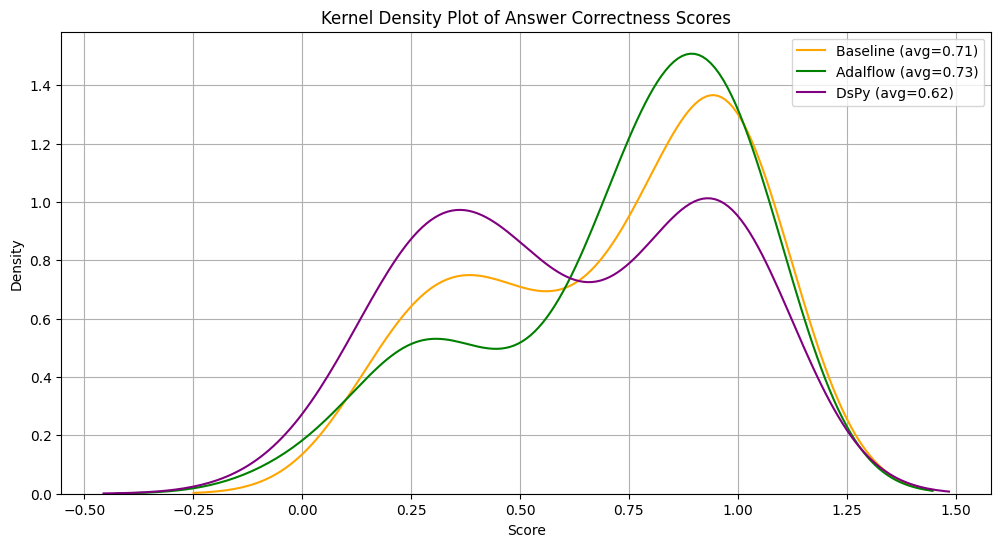

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Kernel density plots
sns.kdeplot(
    final_eval_df['baseline_answer_score'].dropna(),
    color='orange',
    label=f'Baseline (avg={final_eval_df["baseline_answer_score"].mean():.2f})'
)
sns.kdeplot(
    final_eval_df['adalflow_answer_score'].dropna(),
    color='green',
    label=f'Adalflow (avg={final_eval_df["adalflow_answer_score"].mean():.2f})'
)
sns.kdeplot(
    final_eval_df['dspy_answer_score'].dropna(),
    color='purple',
    label=f'DsPy (avg={final_eval_df["dspy_answer_score"].mean():.2f})'
)

plt.xlabel('Score')
plt.ylabel('Density')
plt.title('Kernel Density Plot of Answer Correctness Scores')
plt.legend()
plt.grid(True)
plt.show()